In [1]:
from langgraph.graph import StateGraph, START, END 
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from typing import TypedDict
import os
from dotenv import load_dotenv 

In [2]:
load_dotenv(dotenv_path= r'C:\Users\shekh\OneDrive\Desktop\LangGraph_tut\myenv\.env')

True

In [5]:
HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")


In [4]:
llm = HuggingFaceEndpoint(
    repo_id= 'mistralai/Mistral-7B-Instruct-v0.3',
    task='text-generation',
    huggingfacehub_api_token= HF_TOKEN
)

model = ChatHuggingFace(llm = llm)      

c:\Users\shekh\OneDrive\Desktop\LangGraph_tut\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
## defing the state
class Batsman_state(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int
    strike_rate: float  
    bbp: float  # balls per boundary
    boundry_percentage: float
    summary: str


While working with the parallel workflows, we do not return the complete state as it may cause the confict that every node executing in parallel is performing write opreration on the state. That's why we return the partial state rather than returing the complete state.

In [14]:
def calculate_sr(state: Batsman_state) -> Batsman_state:
    """Calculate the strike rate of the batsman."""
    runs = state['runs']
    balls = state['balls']
    if balls == 0:
        sr = 0.0
    else:
        sr = (runs / balls) * 100
    return {'strike_rate': sr}

In [15]:
def calculate_bbp(state: Batsman_state) -> Batsman_state:
    """Calculate the balls per boundary of the batsman."""
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']
    total_boundaries = fours + sixes
    if total_boundaries == 0:
        bbp = float('inf')  # Infinite if no boundaries
    else:
        bbp = balls / total_boundaries
    return {'bbp': bbp}

In [16]:
def calculate_boundary_percentage(state: Batsman_state) -> Batsman_state:
    """Calculate the boundary percentage of the batsman."""
    runs = state['runs']
    fours = state['fours']
    sixes = state['sixes']
    total_boundaries_runs = (fours * 4) + (sixes * 6)
    if runs == 0:
        bp = 0.0
    else:
        bp = (total_boundaries_runs / runs) * 100
    return {'boundry_percentage': bp}

In [17]:
def summary(state: Batsman_state) -> Batsman_state:
    """Generate a summary of the batsman's performance."""
    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']
    strike_rate = state['strike_rate']
    bbp = state['bbp']
    boundary_percentage = state['boundry_percentage']
    
    summary_text = (
        f"Batsman scored {runs} runs in {balls} balls with a strike rate of {strike_rate:.2f}. "
        f"He hit {fours} fours and {sixes} sixes, resulting in a boundary percentage of {boundary_percentage:.2f}%. "
        f"His balls per boundary is {bbp:.2f}."
    )
    
    return {'summary': summary_text}

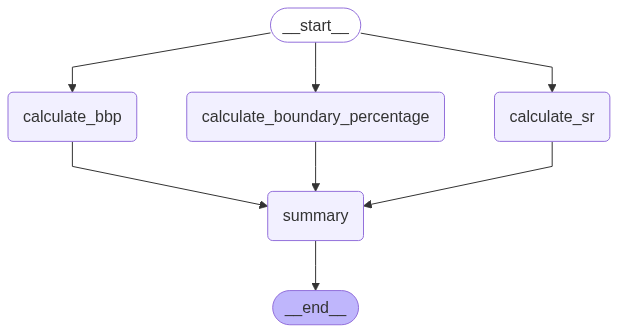

In [18]:
graph = StateGraph(Batsman_state)

graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bbp', calculate_bbp)
graph.add_node('calculate_boundary_percentage', calculate_boundary_percentage)
graph.add_node('summary', summary)

graph.add_edge(START, 'calculate_sr')
graph.add_edge(START, 'calculate_bbp')
graph.add_edge(START, 'calculate_boundary_percentage')
graph.add_edge('calculate_sr', 'summary')
graph.add_edge('calculate_bbp', 'summary')  
graph.add_edge('calculate_boundary_percentage', 'summary')
graph.add_edge('summary', END)

workflow = graph.compile()

workflow

In [19]:
initial_state = {
    'runs': 100,
    'balls': 50,
    'fours': 10,
    'sixes': 5,
}

final_state = workflow.invoke(initial_state)

In [21]:
print(final_state['summary'])

Batsman scored 100 runs in 50 balls with a strike rate of 200.00. He hit 10 fours and 5 sixes, resulting in a boundary percentage of 70.00%. His balls per boundary is 3.33.
